In [1]:
import os
import numpy as np
import pandas as pd

path = r"C:\Users\nero1\.cache\kagglehub\datasets\dhoogla\cicids2017\versions\3"

print("Dataset path:", path)
print("Files:", os.listdir(path))

df_benign = pd.read_parquet(os.path.join(path, "Benign-Monday-no-metadata.parquet"))
df_brute  = pd.read_parquet(os.path.join(path, "Bruteforce-Tuesday-no-metadata.parquet"))

print("Benign shape:", df_benign.shape)
print("Bruteforce shape:", df_brute.shape)

#This code loads the benign and brute-force network traffic datasets from a local KaggleHub directory and prints their file availability and data dimensions to confirm the data was loaded correctly.


Dataset path: C:\Users\nero1\.cache\kagglehub\datasets\dhoogla\cicids2017\versions\3
Files: ['Benign-Monday-no-metadata.parquet', 'Botnet-Friday-no-metadata.parquet', 'Bruteforce-Tuesday-no-metadata.parquet', 'DDoS-Friday-no-metadata.parquet', 'DoS-Wednesday-no-metadata.parquet', 'Infiltration-Thursday-no-metadata.parquet', 'Portscan-Friday-no-metadata.parquet', 'WebAttacks-Thursday-no-metadata.parquet']
Benign shape: (458831, 78)
Bruteforce shape: (389714, 78)


In [2]:
df = pd.concat([df_benign, df_brute], ignore_index=True)

print("Combined shape:", df.shape)
print("\nLabel distribution:")
print(df["Label"].value_counts())

df.head()

#This code combines the benign and attack datasets and checks the label distribution in the merged data.

Combined shape: (848545, 78)

Label distribution:
Label
Benign         839395
FTP-Patator      5931
SSH-Patator      3219
Name: count, dtype: int64


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [3]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
before = df.shape[0]
df.dropna(inplace=True)
after = df.shape[0]

print("Rows before dropna:", before)
print("Rows after dropna:", after)
print("Total nulls remaining:", df.isnull().sum().sum())

#This code removes infinite and missing values from the dataset and shows how many rows were dropped to ensure clean input for modeling.


Rows before dropna: 848545
Rows after dropna: 848545
Total nulls remaining: 0


In [4]:
# 0 = Benign, 1 = Attack (FTP-Patator or SSH-Patator)
df["target"] = (df["Label"] != "Benign").astype(int)

print(df["target"].value_counts())

#This code creates a binary target label where benign traffic is labeled as 0 and all attack traffic is labeled as 1, then displays the class distribution.


target
0    839395
1      9150
Name: count, dtype: int64


In [5]:
X = df.drop(columns=["Label", "target"])
y = df["target"]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

#This code separates the features from the target label and prints their shapes to confirm the data is ready for model training.


X shape: (848545, 77)
y distribution:
 target
0    839395
1      9150
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)

#This code splits the data into training and testing sets while preserving class balance and standardizes the features so they are suitable for machine learning models.


Train: (678836, 77) Test: (169709, 77)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

#This code trains a Random Forest classifier on the training data and evaluates its performance on the test set using classification metrics and a confusion matrix.


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    167879
           1       1.00      1.00      1.00      1830

    accuracy                           1.00    169709
   macro avg       1.00      1.00      1.00    169709
weighted avg       1.00      1.00      1.00    169709

Confusion Matrix:
 [[167879      0]
 [     9   1821]]


Random Forest ROC-AUC: 0.999999567083461


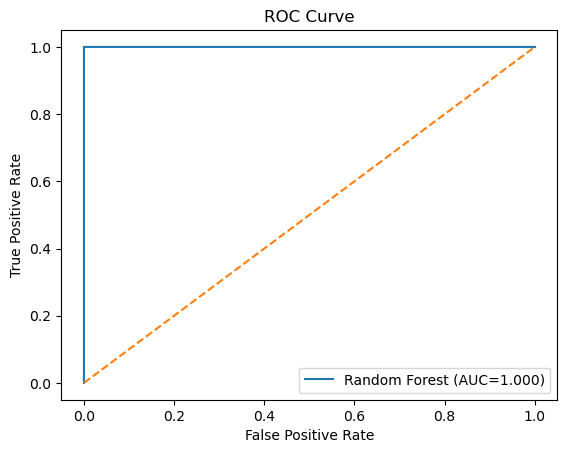

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

y_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("Random Forest ROC-AUC:", auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#This code computes the ROC-AUC score for the Random Forest model and plots the ROC curve to visualize how well the model separates benign and attack traffic across different thresholds.


In [9]:
from sklearn.linear_model import SGDClassifier

svm_like = SGDClassifier(loss="hinge", max_iter=2000, tol=1e-3, random_state=42)
svm_like.fit(X_train_scaled, y_train)
y_pred_svm = svm_like.predict(X_test_scaled)

print("Linear SVM-like (SGDClassifier) Results:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

#This code trains a linear SVM-style classifier using stochastic gradient descent on scaled features and evaluates its performance on the test data.


Linear SVM-like (SGDClassifier) Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    167879
           1       0.97      0.75      0.85      1830

    accuracy                           1.00    169709
   macro avg       0.98      0.87      0.92    169709
weighted avg       1.00      1.00      1.00    169709

Confusion Matrix:
 [[167838     41]
 [   460   1370]]


In [10]:
import pandas as pd

feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 Important Features:")
print(feat_importance.head(15))

#This code extracts and ranks feature importance scores from the Random Forest model to identify which network traffic features contributed most to the predictions.

Top 15 Important Features:
Flow IAT Max                0.046322
Packet Length Variance      0.045624
Packet Length Mean          0.044564
Fwd Packet Length Max       0.038515
Avg Packet Size             0.036781
Packet Length Std           0.036706
Subflow Fwd Bytes           0.036231
Fwd Packets Length Total    0.034808
Packet Length Max           0.034790
Fwd Packet Length Std       0.029611
Total Backward Packets      0.029006
Bwd Packet Length Mean      0.028896
Fwd Packet Length Mean      0.026259
Subflow Bwd Packets         0.025186
Bwd Header Length           0.021181
dtype: float64
